# Evaluacion e implementacion del Modelo
## Macro Average de F1-score
Usaremos con una metrica el ```macro average``` que se calcula como se muestra en la figura. De esta manera podremos usar una sola métrica para medir el rendimiento general del modelo

<img src="images/macro-avg-f1-score.png" class="center" alt="macro avg de f1-score" />

Podemos obtener el ```macro average``` mediante 

```precision_recall_fscore_support(y_test, predictions, average = 'macro')[2]```

## Analisis usando ROC y AUC
- Modelos con mejor performance tendran más Lift, es decir, la curva se alejará más del centro
- Más lift significa que el score de AUC será mayor

## Calibracion del Modelo
Mediremos que tan bien calibradas están las predicciones del modelo.

Lo que esto significa es que queremos que las probabilidades de  ```Default``` representen correctamente el nivel de confianza del modelo
- La probabilidad de ```Default``` tiene un grado de incertidumbre en su prediccion
- Una muestra de prestamos y sus probabilidades de ```default``` predecidas debe ser cercana al porcentage de defaults en esa muestra

<table style="width:100%; align:center; text-align: center">
  <tr>
    <th>Muestra de Prestamos</th>
    <th>Promedio Predicho de PD</th>
    <th>Porcentaje Real de Defaults en la Muestra</th>
    <th>Calibrado?</th>
  </tr>
  <tr>
    <td>10</td>
    <td>0.12</td>
    <td>0.12</td>
    <td>Si</td>
  </tr>
  <tr>
    <td>10</td>
    <td>0.25</td>
    <td>0.65</td>
    <td>No</td>
  </tr>
</table>

En la tabla de arriba de puede ver que en la primera fila para una muestra de 10 prestamos el promedio predicho de los prestamos como defaults es del 12%, el cual coincide con el porcentaje real. En cambio, en la segunda fila el promedio predicho de defaults es de 25%, pero en realidad el 65% de la muestra contiene prestamos con default, por lo que el modelo no está calibrado

Para calcular este valor utilizaremos la funcion ```calibration_curve```. El esta funcion toma como paremetros el test set, las probabildades y ```n_bins``` que representa el numero de muestras a tomar

Llamemos ```PD``` a las probababilidades predichas y ```%Default``` al porcentaje real de ```Defaults``` en la muestra. 
Supongamos que para una de las muestras tenemos los valores:
- ```PD=0.56```
- ```%Default=0.75```

Esto indica que estamos prediciendo menos defaults de los que deberíamos, esto indica varios ```falsos negativos```, lo cual puede afectar negativamente al negocio 

Si ahora para otra muestra tenemos los siguientes valores:
- ```PD=0.94```
- ```%Default=0.66```

En esa muestra encontramos la mayor parte de nuestros falsos positivos. Estas son oportunidades que se pueden perder al predecirlas como default. Pero para este problema resultan menos perjudiciales que los defaults

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, \
                            classification_report, \
                            precision_recall_fscore_support, \
                            roc_auc_score, \
                            confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
cr_loan_clean = pd.read_csv("data/cr_loan_nout_nmiss.csv")

### Creacion de los conjuntos de entrenamiento y testing

In [2]:
cred_num = cr_loan_clean.select_dtypes(exclude=['object'])
cred_str = cr_loan_clean.select_dtypes(include=['object'])

cred_str_onehot = pd.get_dummies(cred_str)
cr_loan_prep = pd.concat([cred_num, cred_str_onehot], axis=1)

In [3]:
# Separacion de los features y la variable a predecir
columns = list(cr_loan_prep.columns)
X_columns = [column for column in columns if column != 'loan_status']
X = cr_loan_prep[X_columns]
y = cr_loan_prep[['loan_status']]

# Creacion del dataset de entrenamiento y de testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)

## Crear Modelos de ```regresion logistica``` y ```gradient boosting trees```

### Logistic Regression

In [4]:
clf_logistic = LogisticRegression(solver='lbfgs').fit(X_train, np.ravel(y_train))
clf_logistic_preds = clf_logistic.predict_proba(X_test)[:,1]
clf_logistic_preds

array([0.4457786 , 0.22344653, 0.28855826, ..., 0.52244951, 0.3704781 ,
       0.12378554])

### GBT

In [5]:
clf_gbt = xgb.XGBClassifier().fit(X_train,np.ravel(y_train))
clf_gbt_preds = clf_gbt.predict_proba(X_test)[:,1]

## Pruebas

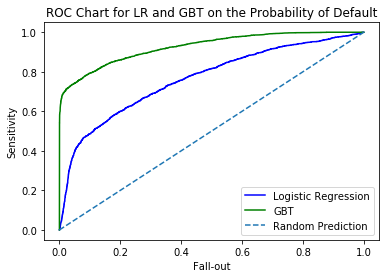

In [6]:
# Componentes del ROC chart
fallout_lr, sensitivity_lr, thresholds_lr = roc_curve(y_test, clf_logistic_preds)
fallout_gbt, sensitivity_gbt, thresholds_gbt = roc_curve(y_test, clf_gbt_preds)

# ROC Chart para ambos modelos
plt.plot(fallout_lr, sensitivity_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fallout_gbt, sensitivity_gbt, color = 'green', label='%s' % 'GBT')
plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart for LR and GBT on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()

In [7]:
# AUC Regresion Logistica
print("Logistic Regression AUC Score: %0.2f" % roc_auc_score(y_test, clf_logistic_preds))

# AUC Gradient Boosting Trees
print("Gradient Boosted Tree AUC Score: %0.2f" % roc_auc_score(y_test, clf_gbt_preds))

Logistic Regression AUC Score: 0.76
Gradient Boosted Tree AUC Score: 0.93


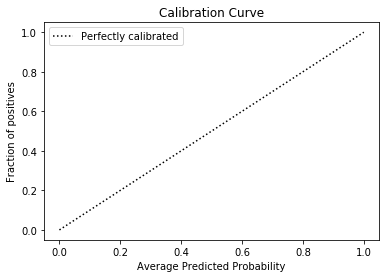

In [8]:
# Creacion de la linea guia para el grafico de la curva de calibracion
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

In [9]:
calibration_curve??

Signature:
calibration_curve(
    y_true,
    y_prob,
    normalize=False,
    n_bins=5,
    strategy='uniform',
)
Source:   
def calibration_curve(y_true, y_prob, normalize=False, n_bins=5,
                      strategy='uniform'):
    """Compute true and predicted probabilities for a calibration curve.

    The method assumes the inputs come from a binary classifier.

    Calibration curves may also be referred to as reliability diagrams.

    Read more in the :ref:`User Guide <calibration>`.

    Parameters
    ----------
    y_true : array, shape (n_samples,)
        True targets.

    y_prob : array, shape (n_samples,)
        Probabilities of the positive class.

    normalize : bool, optional, default=False
        Whether y_prob needs to be normalized into the bin [0, 1], i.e. is not
        a proper probability. If True, the smallest value in y_prob is mapped
        onto 0 and the largest one onto 1.

    n_bins : int
        Number of bins. A bigger number requires more dat

In [10]:
# Calibration curve para LR
frac_of_pos_lr, mean_pred_val_lr = calibration_curve(y_test, clf_logistic_preds, n_bins=20)

# Calibration curve para GBT
frac_of_pos_gbt, mean_pred_val_gbt = calibration_curve(y_test, clf_gbt_preds, n_bins=20)

## Fracciones y promedios para la curva de calibracion

## Visualizacion de la curva de calibracion

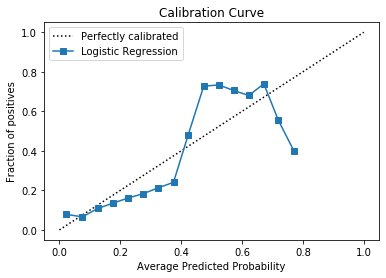

In [11]:
# Se acrega la curva de calibracion para la regresion logistica al grafico
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()

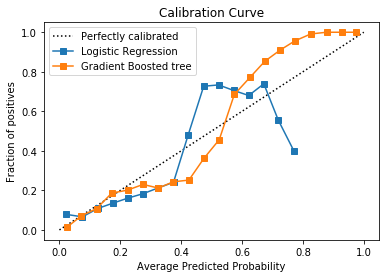

In [12]:
# Se acrega la curva de calibracion para GBT al grafico
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')    
plt.plot(mean_pred_val_lr, frac_of_pos_lr,
         's-', label='%s' % 'Logistic Regression')
plt.plot(mean_pred_val_gbt, frac_of_pos_gbt,
         's-', label='%s' % 'Gradient Boosted tree')
plt.ylabel('Fraction of positives')
plt.xlabel('Average Predicted Probability')
plt.legend()
plt.title('Calibration Curve')
plt.show()